In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

In [ ]:
sns.set(style="whitegrid", context="notebook", palette="muted")

In [4]:
data_path = "../data/processed/breast_cancer_clean.csv"
model_dir = "../outputs/models"
os.makedirs(model_dir, exist_ok=True)

df = pd.read_csv(data_path)
print(df.shape)
df.head()

(569, 31)


,Diagnosis,Radius_mean,Texture_mean,Perimeter_mean,Area_mean,Smoothness_mean,Compactness_mean,Concavity_mean,Concave_points_mean,Symmetry_mean,...,Radius_worst,Texture_worst,Perimeter_worst,Area_worst,Smoothness_worst,Compactness_worst,Concavity_worst,Concave_points_worst,Symmetry_worst,Fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 455, Testing samples: 114


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))

['../outputs/models\\scaler.pkl']

In [7]:
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [8]:
y_pred = xgb_model.predict(X_test_scaled)
y_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9649122807017544
ROC AUC: 0.9940476190476191

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



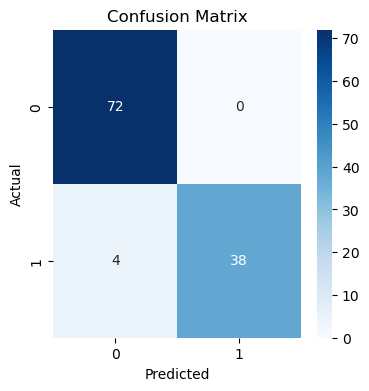

In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

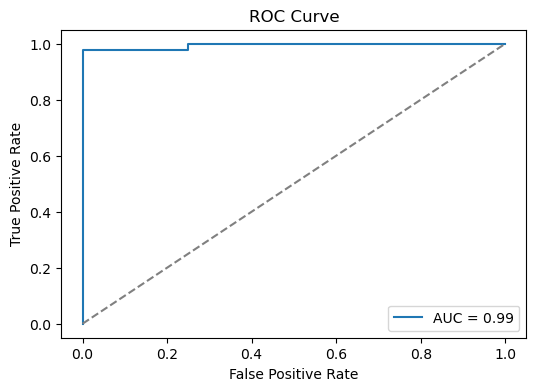

In [10]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

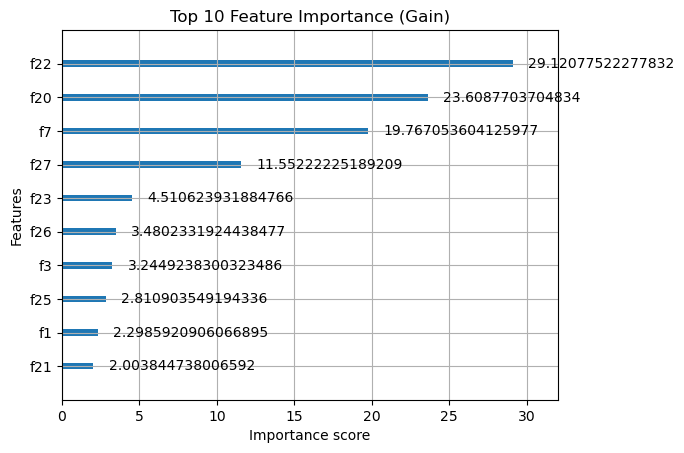

In [11]:
xgb.plot_importance(xgb_model, importance_type="gain", max_num_features=10)
plt.title("Top 10 Feature Importance (Gain)")
plt.show()

In [12]:
model_path = os.path.join(model_dir, "xgboost_breast_cancer.pkl")
joblib.dump(xgb_model, model_path)

['../outputs/models\\xgboost_breast_cancer.pkl']

In [15]:
#testing the model

model = joblib.load("../outputs/models/xgboost_breast_cancer.pkl")
scaler = joblib.load("../outputs/models/scaler.pkl")

new_sample = np.array([[17.99, 10.38, 122.8, 1001.0, 0.1184, 0.2776, 0.3001, 0.1471, 0.2419, 0.07871, 1.095, 0.9053, 8.589, 153.4, 0.006399, 0.04904, 0.05373, 0.01587, 0.03003, 0.006193, 25.38, 17.33, 184.6, 2019.0, 0.1622, 0.6656, 0.7119, 0.2654, 0.4601, 0.1189]])

new_sample_scaled = scaler.transform(new_sample)

pred_proba = model.predict_proba(new_sample_scaled)[0][1]
pred_class = model.predict(new_sample_scaled)[0]

print(f"Prediction: {'Malignant' if pred_class == 1 else 'Benign'}")
print(f"Confidence: {pred_proba:.2f}")

Prediction: Malignant
Confidence: 0.94


C:\Users\shail\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [16]:
#a success!